<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S5_AssignmentSolution2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:

# set the dropout value
dropout_value = 0.10

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()


     # Conv Block1
      self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)) # output_size = 26
            

    # Conv Block2 
      self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10)) # output_size = 24  



    # Conv Block3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 12, kernel_size=(1,1), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(12)) # output_size = 24


    # TRANSITION BLOCK 1
      self.pool1 = nn.Sequential(nn.MaxPool2d(2, 2))# output_size = 12


    # Conv Block4
      self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = (1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)) # output_size = 12


    # Conv Block5
      self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)) # output_size = 12


    # Conv Block6
      self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)) #output_size = 10


    # Conv Block 7
      self.convblock7 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size=(3,3), padding = 0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # output_size = 8

 
    # Conv Block 8
      self.convblock8 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding = 0),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # output_size = 6


  
    # Conv Block9
      self.convblock9 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels=10, kernel_size =(1,1), padding =0, bias=False)) # output_size = 1
      

    # Output Block
      self.gap = nn.Sequential(nn.AdaptiveAvgPool2d(output_size = 1)) # Global Average Pooling


    # DropOut Layer
      self.drop1 = nn.Sequential(nn.Dropout(0.10))


    def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.convblock3(x)
      x = self.pool1(x)
      x = self.drop1(x)
      x = self.convblock4(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.drop1(x)
      x = self.convblock7(x)
      x = self.convblock8(x)
      x = self.gap(x)
      x = self.convblock9(x)
      
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)


  

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 12, 24, 24]             120
              ReLU-8           [-1, 12, 24, 24]               0
       BatchNorm2d-9           [-1, 12, 24, 24]              24
        MaxPool2d-10           [-1, 12, 12, 12]               0
          Dropout-11           [-1, 12, 12, 12]               0
           Conv2d-12           [-1, 16, 12, 12]             192
             ReLU-13           [-1, 16, 12, 12]               0
      BatchNorm2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 16
for epoch in range(1,EPOCHS):
    print('EPOCH: ',epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:  1


Loss=0.12208420038223267 Batch_id=468 Accuracy=86.49: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0862, Accuracy: 9776/10000 (97.76%)

EPOCH:  2


Loss=0.11921487003564835 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0643, Accuracy: 9808/10000 (98.08%)

EPOCH:  3


Loss=0.056586477905511856 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:12<00:00, 38.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9865/10000 (98.65%)

EPOCH:  4


Loss=0.1219799593091011 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:12<00:00, 38.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9894/10000 (98.94%)

EPOCH:  5


Loss=0.0657142624258995 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:12<00:00, 37.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9899/10000 (98.99%)

EPOCH:  6


Loss=0.03670965135097504 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH:  7


Loss=0.022267431020736694 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:12<00:00, 38.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9909/10000 (99.09%)

EPOCH:  8


Loss=0.0782109722495079 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:12<00:00, 38.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9915/10000 (99.15%)

EPOCH:  9


Loss=0.017735609784722328 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 38.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9913/10000 (99.13%)

EPOCH:  10


Loss=0.029879411682486534 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH:  11


Loss=0.12404213100671768 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:11<00:00, 39.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9922/10000 (99.22%)

EPOCH:  12


Loss=0.028681522235274315 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 38.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)

EPOCH:  13


Loss=0.014019091613590717 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:11<00:00, 39.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

EPOCH:  14


Loss=0.01099336612969637 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 38.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.36%)

EPOCH:  15


Loss=0.07841690629720688 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:11<00:00, 39.57it/s]



Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)



Text(0.5, 1.0, 'Test Accuracy')

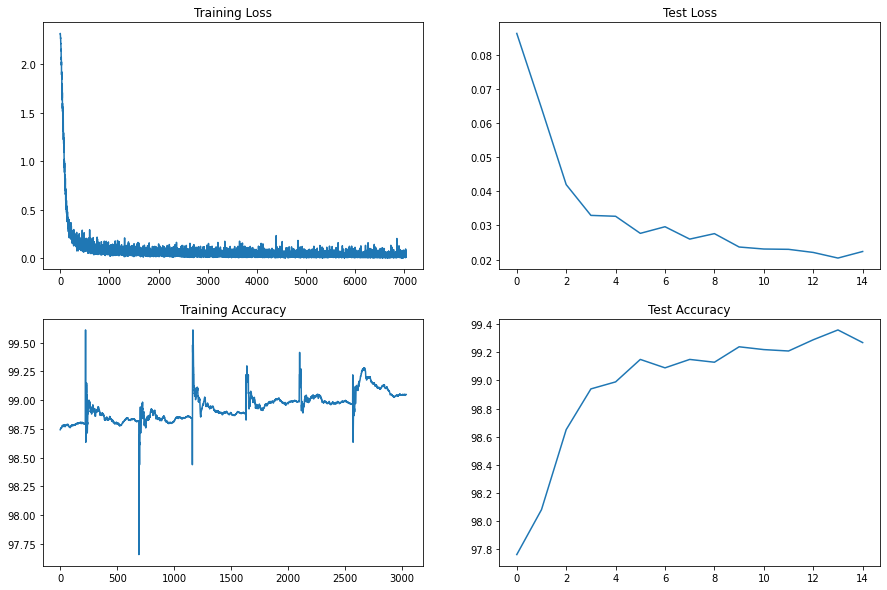

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")